# 1. Introduction

This project use MNIST ("Modified National Institute of Standards and Technology") data set to build a model handwritten images classification. 

## Import Libraries

In [32]:
# Import the nessesery libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
import tensorflow as tf

# 2. Data preparation

## 2.1 Load data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submit = pd.read_csv('./data/sample_submission.csv')

print("Data are ready!!")

Data are ready!!


In [3]:
print(f'Training data size is {train.shape}\nTesting data size is {test.shape}')

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis=1)
Y_train.shape, X_train.shape

((42000,), (42000, 784))

In [5]:
# Load more data sets from mnist of keras
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1.shape, y_train1.shape

((60000, 28, 28), (60000,))

In [6]:
x_train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = x_train1.reshape(-1, 28*28)
X_train1.shape, x_train1.shape

((70000, 784), (70000, 28, 28))

### Is the taget label balanced? 

<AxesSubplot:xlabel='label', ylabel='count'>

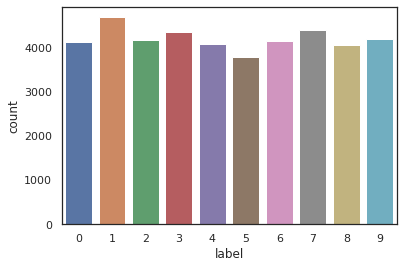

In [7]:
# Print data histogram
sns.countplot(x=Y_train)

## 2.2 Nomarlization 

CNN converg faster on [0..1] data than on [0-255]

In [8]:
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

### Merging all the data 

In [9]:
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

X_train.shape, Y_train.shape

((112000, 784), (112000,))

## 2.3 Reshape 

In [10]:
# Reshape image in 3 dimention because input of CNN is tensor 4 dimension
X_train = X_train.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [11]:
# Convert label to one-hot vector
Y_train = to_categorical(Y_train, num_classes=10)

## 2.4 Split training and validation set 

In [12]:
# Split training set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

### Data Visualization

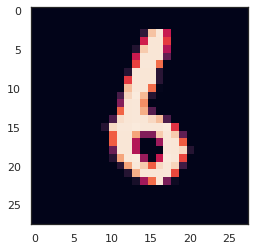

In [13]:
plt.imshow(X_train[189][:,:,0])

# 3. CNN

## 3.1 Define the model 

In [14]:
# Creating CNN model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(5,5), padding="Same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

2022-04-06 21:23:15.304443: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-06 21:23:15.307108: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-06 21:23:15.366018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 21:23:15.366298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-04-06 21:23:15.366346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-06 21:23:15.395655: I tensorflow/stream_executor/platform/default/

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

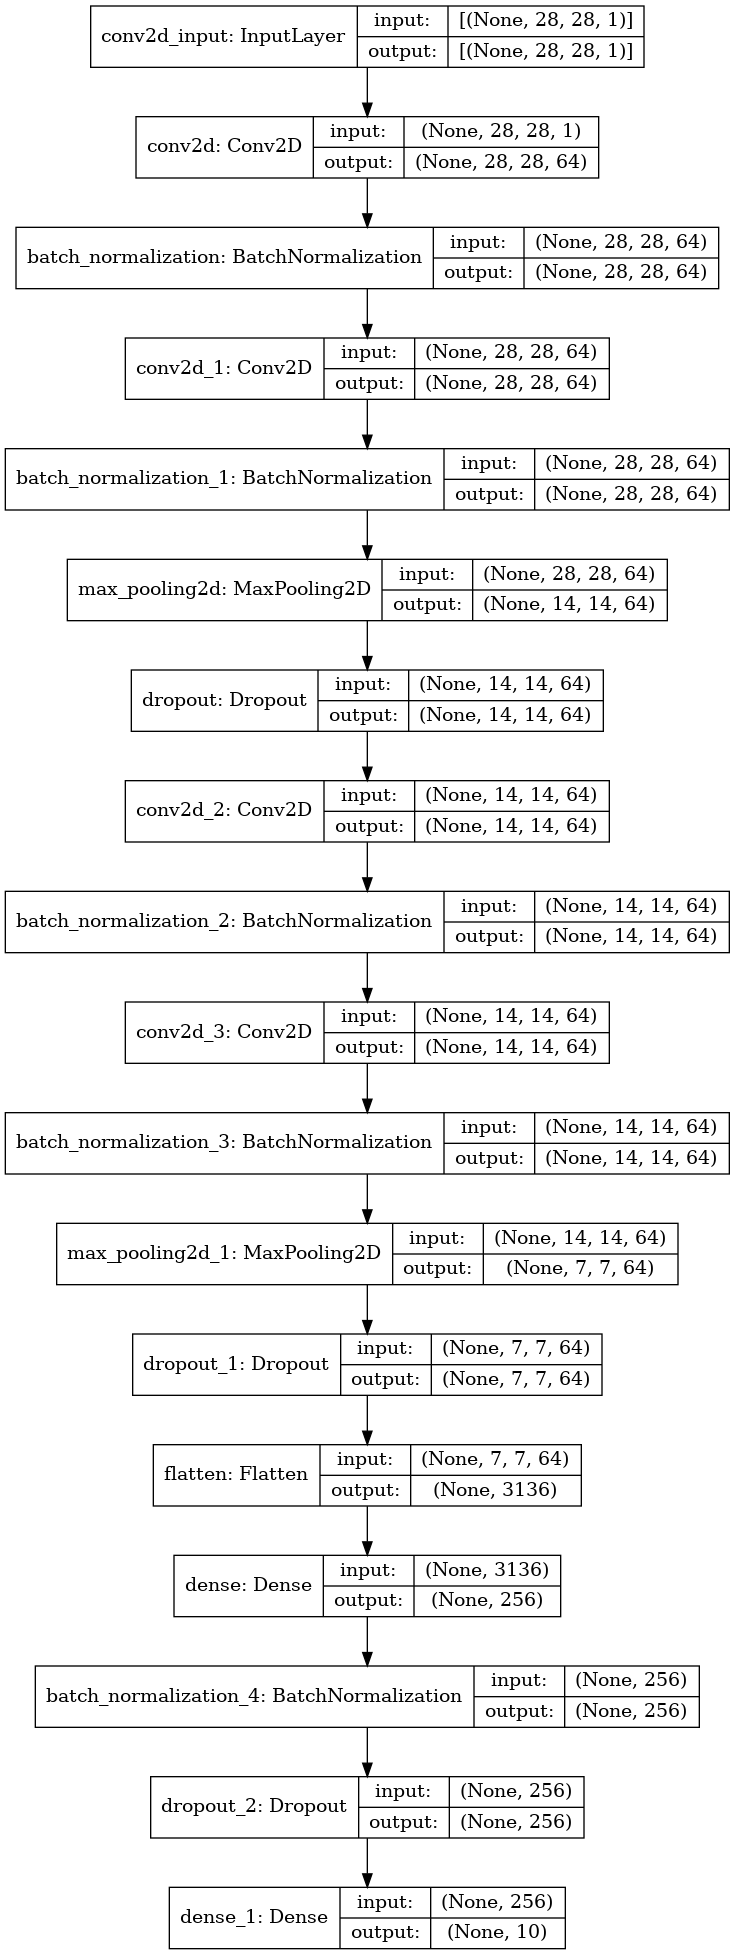

In [16]:
# print out model look
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image('./model.png')

In [17]:
# Define optimizer
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

In [18]:
# Compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
# Callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
csv_logger = tf.keras.callbacks.CSVLogger('./log.csv', separator=',', append=True)

In [20]:
epochs = 50
batch_size = 128

## 3.2 Data augmentation 

In [21]:
datagen = ImageDataGenerator(
    featurewise_center=False, # Set input mean to 0 over the dataset, feature-wise.
    samplewise_center=False, # Set each sample mean to 0.
    featurewise_std_normalization=False, # Divide inputs by std of the dataset, feature-wise.
    samplewise_std_normalization=False, # Divide each input by its std.
    zca_whitening=False, # Apply ZCA whitening.
    rotation_range=10, # Degree range for random rotations.
    zoom_range=0.1, # Range for random zoom.
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip=False, # randomly flip images
    vertical_flip=False # randomly flip images
)

# datagen.fit(X_train)
train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

## 3.3 Model training 

In [22]:
# prediction model
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    verbose=2,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    callbacks=[learning_rate_reduction, csv_logger],
                    validation_steps=X_val.shape[0]//batch_size)

2022-04-06 21:23:16.430246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-06 21:23:16.447235: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/50


2022-04-06 21:23:17.462631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-06 21:23:17.771144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-06 21:23:18.749782: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-06 21:23:18.792171: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


787/787 - 41s - loss: 0.1630 - accuracy: 0.9514 - val_loss: 0.0590 - val_accuracy: 0.9861
Epoch 2/50
787/787 - 26s - loss: 0.0640 - accuracy: 0.9816 - val_loss: 0.0545 - val_accuracy: 0.9853
Epoch 3/50
787/787 - 26s - loss: 0.0527 - accuracy: 0.9849 - val_loss: 0.0343 - val_accuracy: 0.9895
Epoch 4/50
787/787 - 27s - loss: 0.0454 - accuracy: 0.9871 - val_loss: 0.0284 - val_accuracy: 0.9930
Epoch 5/50
787/787 - 29s - loss: 0.0419 - accuracy: 0.9882 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 6/50
787/787 - 30s - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.0239 - val_accuracy: 0.9945
Epoch 7/50
787/787 - 32s - loss: 0.0358 - accuracy: 0.9900 - val_loss: 0.0201 - val_accuracy: 0.9950
Epoch 8/50
787/787 - 32s - loss: 0.0338 - accuracy: 0.9906 - val_loss: 0.0255 - val_accuracy: 0.9933
Epoch 9/50
787/787 - 32s - loss: 0.0336 - accuracy: 0.9910 - val_loss: 0.0278 - val_accuracy: 0.9932
Epoch 10/50
787/787 - 33s - loss: 0.0327 - accuracy: 0.9910 - val_loss: 0.0151 - val_accuracy: 0.9955


In [24]:
model.save_weights('./weights.h5')

# 4. Evaluate the model

## 4.1 Training and validation curves

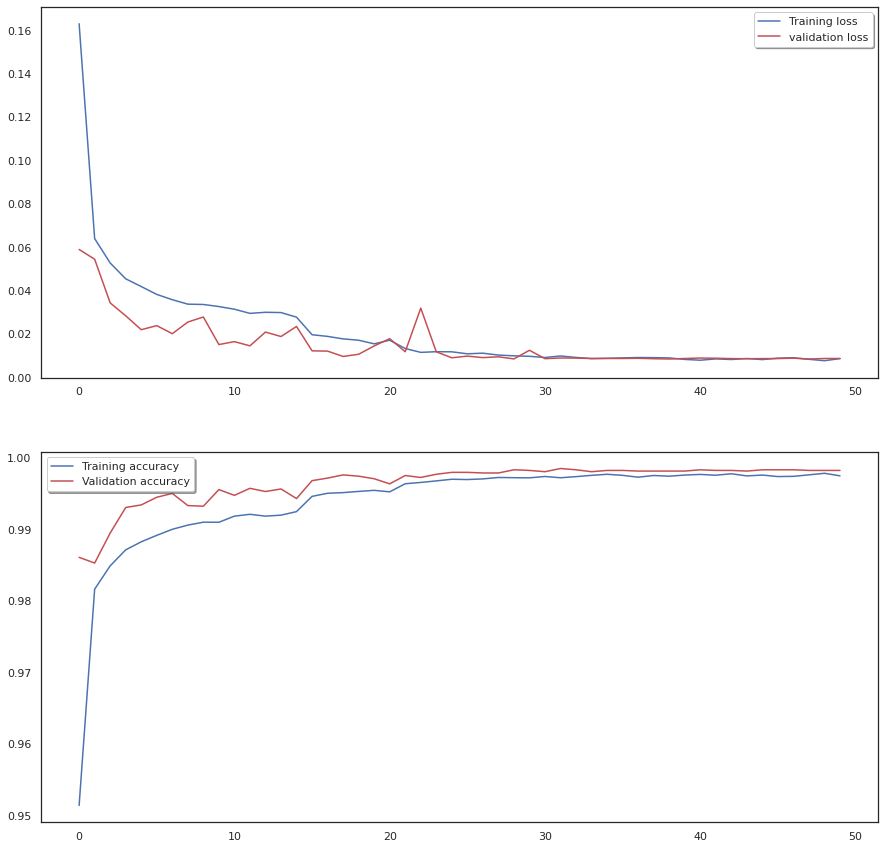

In [25]:
# Draw loss and accuracy curves of training set and validation set
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix 

In [30]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j]),
        horizontalalignment='center',
        color='white' if cm[i,j] > thresh else 'black'
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

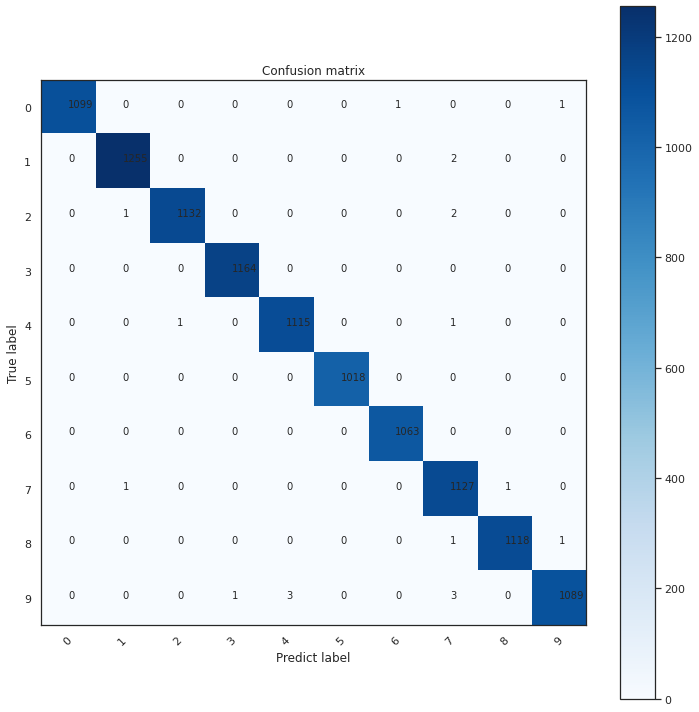

In [33]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [34]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [35]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

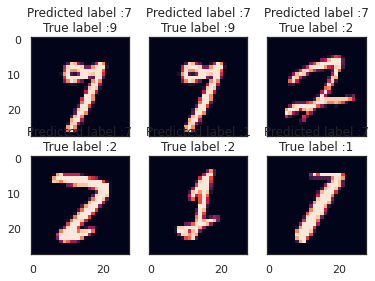

In [36]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# 5. Pediction and submition

In [37]:
# Make predicttion
results = model.predict(test)

# Convert one-hot to number
results = np.argmax(results, axis=1)

results = pd.Series(results, name='label')

2022-04-06 22:22:25.519084: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 87808000 exceeds 10% of free system memory.


In [38]:
# Save the final result
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)

submission.to_csv('cnn_mnist_submission.csv', index=False)